In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import casadi
import numpy as np
import l4casadi as l4c
from SHARED.aux_functions import *
from SHARED.model import *
from RL.environment import *
from stable_baselines3.common.env_checker import check_env
from SHARED.display_trajectories import print_metrics
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3 import DDPG
from stable_baselines3 import PPO, SAC,TD3
from RL.helperFunctions import *
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from tqdm import tqdm
from math import isclose
from enum import Enum
import time
from numpy import asarray
from numpy import savetxt
import copy 
from SHARED.vf_TD_class import *
from SHARED.vf_TR_class import *

print("Torch version:",torch.__version__)
print("Is CUDA enabled?",torch.cuda.is_available())


2024-06-02 20:17:37.133494: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 20:17:37.158897: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 20:17:37.158922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 20:17:37.159585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-02 20:17:37.163611: I tensorflow/core/platform/cpu_feature_guar

Torch version: 2.2.0+cpu
Is CUDA enabled? False


In [2]:
class terminal_function(Enum):
    vf = 1
    qf = 2

In [3]:
T = (1) #Time horizon (seconds)
N = (int) (3600*T)//dT#Number of Control Actions
# N=1
print (N)
F,g = model_functions()
GAMMA = 1 #make sure this is the same as the loaded agent
stochastic = False
num_simulations = 30 if stochastic else 1



use_trained_vf = True
use_growth_dif  =False
model_path = "models/SAC/deterministic/best_model_agent_11_abs.zip"
env_path = "models/SAC/deterministic/vecNormEnv_agent_11_abs.pkl"


print (f"Using Trained vf: {use_trained_vf}")
print (model_path)
print (env_path)


12
Using Trained vf: True
models/SAC/deterministic/best_model_agent_11_abs.zip
models/SAC/deterministic/vecNormEnv_agent_11_abs.pkl


##### Loading Env,Model, and value function

In [4]:
#Normalized Environment
env_norm = greenhouseEnv(use_growth_dif=use_growth_dif)
env_norm = DummyVecEnv([lambda: env_norm])
env_norm = VecNormalize(env_norm, norm_obs = True, norm_reward = False, clip_obs = 10.,gamma=GAMMA)
env_norm = env_norm.load(env_path,env_norm)
env_norm.training = False

variance = env_norm.obs_rms.var
mean = env_norm.obs_rms.mean

new_mean = np.array([mean[0],mean[7]])
new_var = np.array([variance[0],variance[7]])


#Unnormalized Environment, used for evaluation
env = greenhouseEnv(use_growth_dif=use_growth_dif)
env.random_starts = False
env.stochastic = False


#Loading agent
model  = SAC.load(model_path,env=env_norm)
  
#Trained Vf function
# trained_vf = torch.load("models/VF/Deterministic/agent_111.zip")

# trained_vf = torch.load("models/VF/Deterministic/mpc_1hr_tr.zip")
# trained_vf = torch.load("models/VF/Deterministic/agent_11_abs_tr_deep_13.zip")
# trained_vf = torch.load("models/VF/Deterministic/agent_11_abs_tr_deep_reduced.zip")
trained_vf = torch.load("models/VF/Deterministic/agent_11_abs_tr_shallow_full.zip")
trained_vf.eval()

neural_net(
  (fc1): Linear(in_features=12, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (act_fn): Tanh()
)

Casadi Neural Nets and Functions

In [5]:


x = casadi.MX.sym('x')
mu = casadi.MX.sym('mu')
sigma_sq = casadi.MX.sym('sigma_sq')
normalized_obs = (x - mu) / casadi.sqrt(sigma_sq + 1e-08)
# normalized_obs_clipped = casadi.if_else(normalized_obs > 10, 10, 
#                                     casadi.if_else(normalized_obs < -10, -10, normalized_obs))

norm_obs_agent = casadi.Function('normalized_obs', [x, mu, sigma_sq], [normalized_obs])

In [6]:
observation = casadi.MX.sym('observation')
min_val = casadi.MX.sym('min_val')
max_val = casadi.MX.sym('max_val')

# Define symbolic expression
obs_norm = 10 * ((observation - min_val) / (max_val - min_val))
normalizeObs_casadi = casadi.Function('normalizeObs', [observation, min_val, max_val], [obs_norm])


state_norm = 10 * ((observation - min_val) / (max_val - min_val)) - 5
normalizeState_casadi = casadi.Function('normalizeObs', [observation, min_val, max_val], [state_norm])



In [7]:
#Class used for my value function   --> from models such as PPO
class value_fn (nn.Module):
    def __init__(self, feature_extractor, value_net ) -> None:
        super(value_fn,self).__init__()
        feature_extractor.eval()
        value_net.eval()
        self.extractor = feature_extractor
        self.val_net = value_net
    def forward(self,x):
        with torch.no_grad():
            output1 = self.extractor(x)
            output2 = self.val_net(output1)
        return output2 
        
#Class used for state-action value function --> from models such as DDPG, SAC, TD3      
class qvalue_fn(nn.Module):
    def __init__(self, qf_net) -> None:
        super(qvalue_fn,self).__init__()
        qf_net.eval()
        self.qf_net = qf_net
    def forward(self,x):
        output1 = self.qf_net(x)
        return output1
     
class actor_fn(nn.Module):
    def __init__(self, latent_pi, mu) -> None:
        super(actor_fn,self).__init__()
        self.latent_pi = latent_pi
        self.mu = mu
        self.act_fn = nn.Tanh()
        
    def forward(self,x):
        x = self.latent_pi(x)
        x = self.act_fn(self.mu(x))
        return x   

   


In [8]:
#creating casadi verions of the value functions
vf_casadi_model = l4c.L4CasADi(
trained_vf,
model_expects_batch_dim=True,
device='cpu', 
name='vf' 
) 
#exact model
# obs_sym_vf = casadi.MX.sym('obs', 2, 1)
obs_sym_vf = casadi.MX.sym('obs', 12, 1)
vf_out = vf_casadi_model(obs_sym_vf)
vf_function = casadi.Function('vf', [obs_sym_vf], [vf_out])

#Approximated Model
vf_casadi_model_approx = l4c.realtime.RealTimeL4CasADi(trained_vf, approximation_order=1)
vf_casadi_approx_sym_out = vf_casadi_model_approx(obs_sym_vf)
vf_casadi_approx_func = casadi.Function('vf_approx',[obs_sym_vf,vf_casadi_model_approx.get_sym_params()],[vf_casadi_approx_sym_out])

#Qf from agent
qf_casadi_model = l4c.L4CasADi(
qvalue_fn(model.critic.q_networks[0]),
model_expects_batch_dim=True,
device='cpu', # Device in ['cpu', 'gpu', 'mps']
name='qf' # Unique name
) 
obs_and_action_sym = casadi.MX.sym('obs_and_a', 15, 1)
qf_out = qf_casadi_model(obs_and_action_sym)
qf_function = casadi.Function('qf', [obs_and_action_sym], [qf_out])


#Creating casadi version of the actor
actor_casadi_model = l4c.L4CasADi(
actor_fn(model.actor.latent_pi,model.actor.mu),
model_expects_batch_dim=True,
device='cpu', 
name='actor' 
)

obs_sym = casadi.MX.sym('obs', 12, 1)
action_out = actor_casadi_model(obs_sym)
actor_function = casadi.Function('action', [obs_sym], [action_out])
    
#Test whether casadi NN outputs the same as pytorch NN
obs,_ = env.reset()
obs_norm = env_norm.normalize_obs(obs)

action = np.array([0.5,0.1,1])

# obs_tensor = torch.tensor([obs_norm[0],obs_norm[7]], dtype = torch.float32).unsqueeze(0)
obs_tensor = torch.tensor(obs_norm, dtype = torch.float32).unsqueeze(0)
print (float(trained_vf(obs_tensor)) )
# print (vf_function([obs_norm[0],obs_norm[7]]))
print (vf_function(obs_norm))
# assert float(trained_vf(obs_tensor)) == vf_function([obs_norm[0],obs_norm[7]])
assert float(trained_vf(obs_tensor)) == vf_function(obs_norm)


q = qvalue_fn(model.critic.q_networks[0])
inputs = torch.cat([torch.tensor(obs_norm, dtype = torch.float32),torch.tensor(action, dtype = torch.float32)], dim = 0)


assert float(q(inputs)) == qf_function(np.array(inputs).reshape(15,1))


print (actor_function(obs_norm.reshape(12,1)))
print (model.predict(obs_norm,deterministic=True)[0])


/home/murray/Documents/Skripsie/code/.venv/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


4.18896484375
4.18896
[-0.622623, -0.413142, -0.977092]
[-0.62262326 -0.41314167 -0.97709227]


Actor Unroll

In [9]:
def unroll_actor(horizon,freeze = True):
    log = {
        "obs":[],
        "x":[],
        "u":[],
    }
    obs_log,obs_norm_log,x_log,u_log = [],[],[],[]
    total_cost = 0
    rewards_log = []
    
    obs = env.get_obs()
    obs_log.append(obs)
    x_log.append(env.get_x())
    
    #Freeze environment 
    if freeze:
        env.freeze() #freeze variables
    
    done = False
    for i in range (0,horizon):
        
        # obs_norm = norm_obs(obs).toarray().squeeze(-1)
        obs_norm = norm_obs_agent(obs,mean,variance).toarray().ravel()
        action = actor_function(obs_norm).toarray().ravel()
        obs, reward, done, _,info = env.step(action)
        x = info["x"]
        
        total_cost += reward
        rewards_log.append(reward)
        obs_log.append(obs)
        obs_norm_log.append(norm_obs_agent(obs,mean,variance).toarray().ravel())
        x_log.append(x)
        u_log.append(obs[4:7])
        
        # if done:
        #     break
    
    #unfreeze environment
    if freeze:
        env.unfreeze()
    log["obs"] = np.vstack(obs_log).transpose()
    log["x"] = np.vstack(x_log).transpose()
    log["u"] = np.vstack(u_log).transpose()
    log["obs_norm"] = np.vstack(obs_norm_log).transpose()
    log["total_reward"] = total_cost
    log["reward_log"] = np.array(rewards_log)
    return log


obs,_ = env.reset()
obs_norm = norm_obs_agent(obs,mean,variance)
print (obs)
print (obs_norm)
print()

new_obs = np.array([obs[0],obs[7]])

print (norm_obs_agent(new_obs,new_mean,new_var))
# print (norm_obs_agent(np.array([obs[0],obs[7]]),mean,variance))
# print ()
n  = unroll_actor(max_steps)

# print (n['obs_norm'].shape)

# # print (n['reward_log'])
# # print (n['total_reward'])
# print (sum(n['reward_log']))
# # print (n["x"][0,-1])
# plt.plot (n['reward_log'])
# 
# n  = unroll_actor(max_steps)

# print (n['x'][0,-2])


[3.5000001e-03 5.3726019e+02 1.5000000e+01 6.2643951e+01 0.0000000e+00
 0.0000000e+00 5.0000000e+01 0.0000000e+00 0.0000000e+00 8.6332666e-04
 5.5999999e+00 5.4981452e-03]
[-1.23964, -1.23541, 0.650497, -2.05271, -0.887606, -0.513322, 1.21346, -1.73055, -0.582795, -0.184527, -0.781107, -0.87123]

[-1.23964, -1.73055]


Quick Test of the Environment

4.270372322252317
----------------------------  -----------
EPI                (EURO/m2)     4.95775
Total growth       (kg/m2)       0.303805
Total C02 usage    (kg/m2)       1.05712
Total Heating      (kWh)        12.5768
Computational Time (s)
Temp violations    (deg)       109.836
C02 violations     (ppm)      3223.15
FINAL PERFORMANCE                4.27202
----------------------------  -----------
5415.912763519461


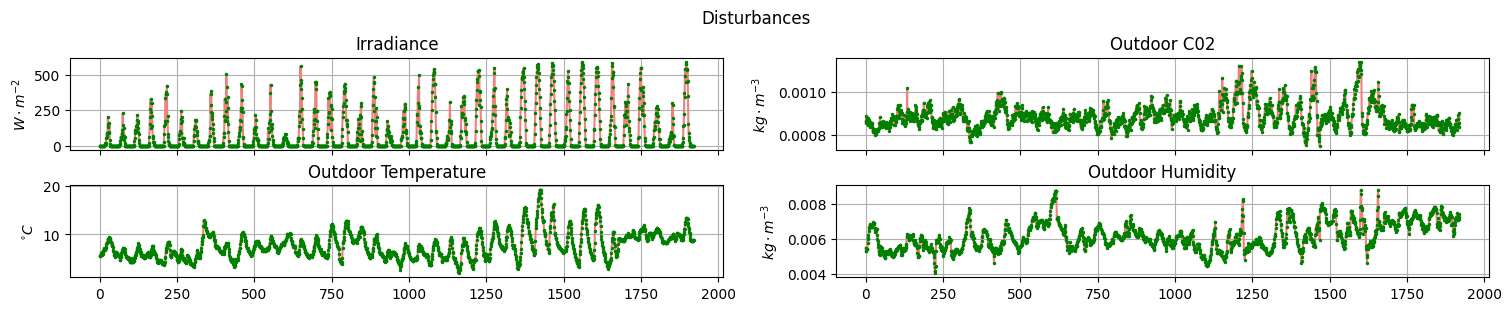

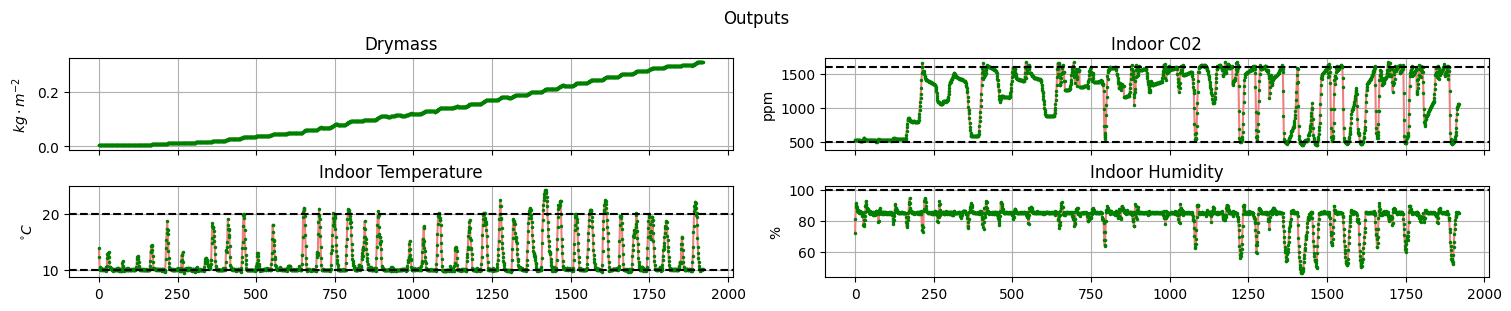

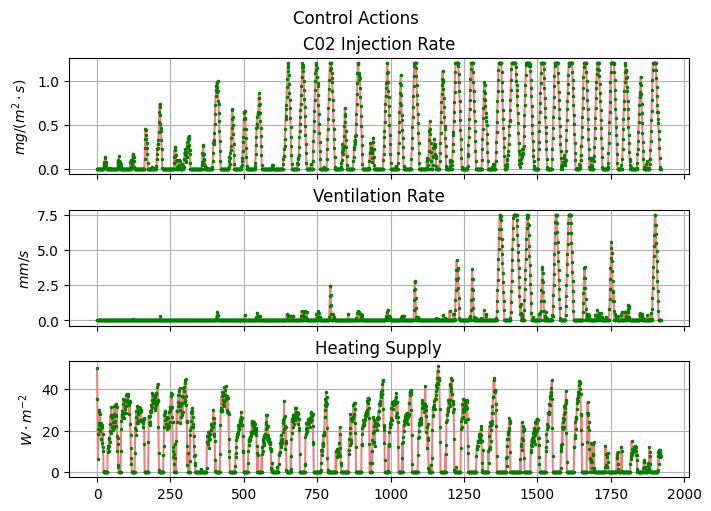

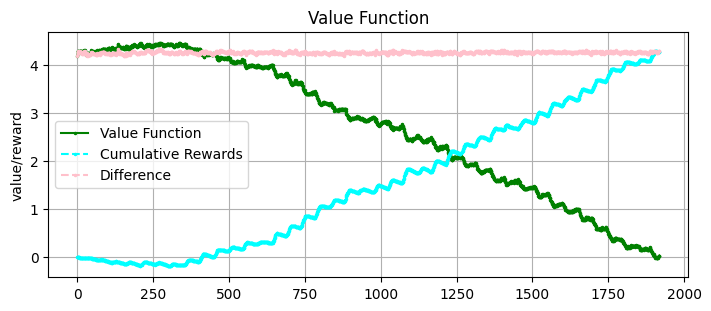

In [10]:
if True:
    #Recorded outputs and states
    obs_log = []
    output_log = []

    #Recorded value and reward recieved from env
    values = []
    total_reward=0
    rewards_log = []


    #Recorded rewards/penalites from evaluation
    cum_reward_log = [0]
    cum_penalties = [0]

    total_reward_eval=0
    total_penalty_eval=0

    #Recorded Computational time for control action
    comp_time_log = []

    #Reward evaluation function
    evaluate_rewards = partial(reward_evaluation,
                        constraint_mins=np.array([C02_MIN_CONSTRAIN_MPC, TEMP_MIN_CONSTRAIN_MPC, HUM_MIN_CONSTRAIN]),
                        constraint_maxs=np.array([C02_MAX_CONSTRAIN_MPC, TEMP_MAX_CONSTRAIN_MPC, HUM_MAX_CONSTRAIN]))

    obs,_ = env.reset()
    obs_log.append(obs)

    done = False
    while not done:
    # for i in range (max_steps):
        
        obs_norm = norm_obs_agent(obs,mean,variance).toarray().squeeze(-1)
        action = actor_function(obs_norm.reshape(12,1)).toarray()
        # log = unroll_actor(obs, N)
        obs, reward, done,_, info = env.step(action.reshape(1,3))
        
        with torch.no_grad():
            if use_trained_vf:
                # obs_norm = norm_obs_agent(np.array([obs[0],obs[7]]),new_mean,new_var).toarray().squeeze(-1).reshape(2,1)
                # obs_norm = normalizeState_casadi(np.array([obs[0],obs[7]]),np.array([x_min[0],0]), np.array([x_max[0],max_steps]))
                # inputs = [obs_norm[0],obs_norm[7]]
                vf = vf_function(obs_norm)
            else:
                obs_norm = norm_obs_agent(obs,mean,variance).toarray().squeeze(-1)
                inputs = np.concatenate([obs_norm,action.reshape(3,)]).reshape(15,1)
                vf = qf_function(inputs)
        values.append(vf) 
        
        #To compare with MPC reward
        u_opt = obs[4:7]       
        reward_eval, penalties_eval = evaluate_rewards(delta_drymass=obs[0],control_inputs=u_opt,
                        outputs2constrain=info['output'][1:]) 
        
        
        cum_reward_log.append(cum_reward_log[-1] + reward_eval - penalties_eval)
        
        
        total_reward += reward
        rewards_log.append(total_reward)
        
        output_log.append(info['output'])
        obs_log.append(obs)   
        
    obs_log = np.vstack(obs_log)
    output_log = np.vstack(output_log[:])
    values = np.vstack(values[:-1]).squeeze(-1)
    rewards_log = np.reshape(np.array([rewards_log[:-1]]),values.shape)


    U_log = obs_log[:,4:7]
    Y_log = output_log
    D_log = obs_log[:,8:]


    print (total_reward)
    print_metrics(Y_log, U_log, D_log, vf=values,rewards=rewards_log,day_range=(0,40))
    print (cum_reward_log[-1])


Value Function Visualization

In [11]:
# N=2
print (N)

env.set_env_state(x0,x0,u0,0)
logs = unroll_actor(horizon=N)
xx = logs['x']
uu = logs['u']


casadi_vf_approx_param = vf_casadi_model_approx.get_params(np.zeros(12))
coef_size = casadi_vf_approx_param.shape[0]
print (coef_size)

12
25


In [12]:

# ((observation - min)/(max-min))
def normalize_reward(r):
    min = -0.005
    max = 0.03
    return ((r - min)/(max-min))

def normalize_vf(v):
    min = 0
    max = 5
    return ((v - min)/(max-min))



In [13]:
opti = casadi.Opti()
mpc_reward = partial(reward_function, return_type = "DM")
get_d = partial(get_disturbance,weather_data = weather_data,start_time=start_time,Np=N+1, dt=dT)
#State Variables
X = opti.variable(4,N+1)    #->Drymass              (kg/m2)
                            #->Indoor C02           (kg/m3)
                            #->Indoor Temp          (deg C)
                            #->Indoor Humidity      (kg/m3)
#Output Variables
Y  = opti.variable(4,N)     #->Drymass              (kg/m2)
                             #->Indoor C02           (ppm)
                             #->Indoor Temp          (deg C)
                             #->Indoor Humidity      (%)
#Disturbance Variables
D = opti.parameter(4,N+1)     #->Irradiance           (W/m2)
                            #->Outdoor C02          (kg/m3)
                            #->Outdoor Temp         (deg C)
                            #->Outdoor Humidity     (kg/m3)
#Control Variables
U = opti.variable(3,N)      #->C02 Injection        (mg/(m2.s))
                            #->Ventilation          (mm/s)
                            #->Heating              (W/m2)

P = opti.variable (4,N)     #Penalties for temp ub and lb, co2 ub and lb  

TAYLOR_COEFS = opti.parameter(coef_size)

A = opti.variable(3)
opti.subject_to(-1<=(A<=1))

time_step = opti.parameter(1,1)  

       
#Initial Values
px = opti.parameter(4,1)
pu = opti.parameter(3,1)


opti.set_initial(X,xx)
opti.set_initial(U,uu)

#Terminal constraints
terminal_x = opti.parameter(4,1)
terminal_u = opti.parameter(3,1)

#Guesses for trajectoreis
# u_traj_guess = opti.parameter(3,N)
# x_traj_guess = opti.parameter(4,N+1)


#Set Parameters
opti.set_value(D,get_d(0))
opti.set_value(px,x0)
opti.set_value(pu,u0)
opti.set_value(time_step,0)
opti.set_value(terminal_x,xx[:,-1])
opti.set_value (terminal_u,uu[:,-1])
# opti.set_value(u_traj_guess,uu)
# opti.set_value(x_traj_guess,xx)
opti.set_value(TAYLOR_COEFS,vf_casadi_model_approx.get_params(np.zeros(12)))

# opti.subject_to(0.95*terminal_x<= (X[:,-1]  <= 1.05*terminal_x))
# opti.subject_to(0.95*terminal_u<= (U[:,-1]  <=1.05*terminal_u))


#VF approximation

# opti.subject_to(X[:,-1]  == terminal_x)#Terminal Constraint
# opti.subject_to(U[:,-1]  == terminal_u)#Terminal Constraint

# 0,1500,15,90,0.5,1,30,0,250,0.0009,10,0.006]
# OBS = casadi.vertcat(Y[0,-1],time_step+N)      
OBS = casadi.vertcat(Y[0,-1],g(terminal_x,nominal_params)[1:],terminal_u,time_step+N,D[:,-1])           
OBS_NORM = opti.variable(12)
# OBS_NORM = norm_obs_agent(OBS,mean,variance)
opti.subject_to(OBS_NORM == norm_obs_agent(OBS,mean,variance))    
# opti.subject_to(OBS_NORM == normalizeState_casadi(OBS,np.array([x_min[0],0]), np.array([x_max[0],max_steps])))    
#Cost Function
J = 0

#Set Constraints and Cost Function
for k in range(0,N):
    opti.subject_to(X[:,k+1] == F(X[:,k],U[:,k],D[:,k], nominal_params))           
    opti.subject_to(Y[:,k] == g(X[:,k+1],nominal_params))                                                #Output  Constraints
    opti.subject_to(u_min <= (U[:,k] <= u_max))         
    
    #Linear penalty functions
    opti.subject_to(P[:,k] >= 0)
    opti.subject_to(P[0,k] >= pen_c02     * (C02_MIN_CONSTRAIN_MPC - Y[1,k]))  
    opti.subject_to(P[1,k] >= pen_c02     * (Y[1,k] - C02_MAX_CONSTRAIN_MPC))  
    opti.subject_to(P[2,k] >= pen_temp_lb * (TEMP_MIN_CONSTRAIN_MPC - Y[2,k])) 
    opti.subject_to(P[3,k] >= pen_temp_ub * (Y[2,k] - TEMP_MAX_CONSTRAIN_MPC))  
    # opti.subject_to(HUM_MIN_CONSTRAIN <= (Y[3,k]<= HUM_MAX_CONSTRAIN))         #Hum min max constraints   
    
    J -= mpc_reward(delta_drymass=(X[0,k+1]-X[0,k]), control_inputs=U[:,k])
    J += (P[0,k] + P[1,k] + P[2,k] + P[3,k])    
    
    if k < N-1:                                         
        opti.subject_to(-delta_u<=(U[:,k+1] - U[:,k]<=delta_u))
    
# Value Function insertion
if use_trained_vf:
    print ("Using self trained vf")
    # J_terminal = vf_casadi(normalizeObs_casadi(casadi.vertcat(Y[:,-1],U[:,-1],time_step+N,D[:,-1]),obs_min, obs_max)) 
    # (1.01**(-(time_step+N - 2)))*
    J_terminal = vf_function(OBS_NORM) 
    # J_terminal = vf_casadi_approx_func(OBS_NORM,TAYLOR_COEFS)
else:
    # pass
    print ("using QF")
    opti.subject_to(OBS[0] - Y[0,-1] == 0)
    opti.subject_to(OBS[1:4] - Y[1:,-1] == 0)
    opti.subject_to(OBS[4:7] - U[:,-1] == 0)
    opti.subject_to(OBS[7] - time_step + N == 0)
    opti.subject_to(OBS[8:] - D[0:,-1] == 0)
    opti.subject_to(OBS_NORM == norm_obs_agent(OBS,mean,variance))
    J_terminal = qf_function(casadi.vertcat(OBS_NORM,A))  
    # J_terminal = 0

J -= J_terminal


opti.subject_to(-delta_u <= (U[:,0]-pu <= delta_u))                             #Initial change in input Constraint
opti.subject_to(X[:,0] == px)        

opti.minimize(J)

#Solver --> ipopt, bonmin, snopt, blocksqp,sqpmethod, scpgen
opts = {}
opts["print_time"] = False
opts["ipopt.print_level"]= False
opts["verbose"] =  False
opts["ipopt.max_iter"] = 5000
opts["ipopt.nlp_scaling_method"]       = 'gradient-based'
# opts["ipopt.warm_start_init_point"]    = 'yes'
opts["ipopt.warm_start_entire_iterate"]    = 'yes'
# opts["ipopt.bound_push"] = 0.01
# opts["ipopt.bound_frac"] = 0.01
# opts["ipopt.slack_bound_push"] = 0.01
# opts["ipopt.slack_bound_frac"] = 0.01
# opts["ipopt.bound_relax_factor"] = 1e-3

opti.solver('ipopt',opts)
sol = opti.solve()
MPC = opti.to_function('MPC',
                       [px,D,pu,time_step,terminal_x,terminal_u,X,U,TAYLOR_COEFS],
                       [U[:,0],U,X,J,J_terminal, OBS_NORM],
                       ['px','pu','D','time_step','terminal_x','terminal_u','initial_X','initial_U','taylor_coefs'],
                       ['u_opt','u_traj','x_traj','J','J0','terminal_obs'])
# MPC = opti.to_function('MPC',[px,D,pu,time_step,terminal_x,terminal_u,X,U],[U[:,0],U,X,J],['px','D','pu','time_step','xx','uu',"initialX","initialU"],['u_opt','u_traj','x_traj','cost'])

# print (MPC(x0,get_d(0),u0,0,xx[:,-1],uu[:,-1],xx,uu))
_,_,_,cost,cost0,_ = MPC(x0,get_d(0),u0,0,xx[:,-1],uu[:,-1],xx,uu,vf_casadi_model_approx.get_params(np.zeros(12)))
print (cost)
print (cost0)
print (cost+cost0)
# print (MPC([0.0025,0.001,15,0.008],np.zeros((4,12)),[0,0,50],10*np.ones((1,12)),20*np.ones((1,12))))
# MPC =casadi.Function.load('MPC.casadi')
# casadi.DM.set_precision(15)

#0.0375269

Using self trained vf

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

-4.27698
4.29422
0.0172354


#### Simulation

In [14]:
for sim_num in range (num_simulations):
        
    #Save directories
    impl = "/Impl_4_V3.1/"
    main_path = "Stochastic" + impl+'/scale_' + str(noise_scale) +  str (T) + '_hr/' if stochastic else "Deterministic/" +impl+ str (T)+ '_hr'
    directory = 'results/RL_MPC/' + main_path + '/Sim_' + str(sim_num) + '/'
    print (directory)
    os.makedirs(directory, exist_ok=True)
    #Initial Conditions
    x = np.copy(x0)
    x_prev = np.copy(x0)
    u_opt = np.copy(u0)
    get_d = partial(get_disturbance,weather_data = weather_data,start_time=start_time,Np=N+1, dt=dT)

    #Reward evaluation function
    evaluate_rewards = partial(reward_evaluation,
                        constraint_mins=np.array([C02_MIN_CONSTRAIN_MPC, TEMP_MIN_CONSTRAIN_MPC, HUM_MIN_CONSTRAIN]),
                        constraint_maxs=np.array([C02_MAX_CONSTRAIN_MPC, TEMP_MAX_CONSTRAIN_MPC, HUM_MAX_CONSTRAIN]))



    #Logging states, outputs, disturbances and control inputs
    X_log, D_log, Y_log, U_log = [],[],[],[]
    x_ref = []
    u_ref = []
    x_traj_ref = []
    d_ref = []
    J_log = []
    
    guess_J = []
    actual_J = []
    
    
    #Logging reward and penalties
    cum_reward_log = [0]
    cum_penalties = [0]
    reward = 0
    debugg = []

    total_reward=0
    total_penalty=0

    #Logging compute time for control action
    comp_time_log = []

    
    env.reset()
    for k in tqdm(range(0,max_steps)):
        #Get Disturbance
        d = get_d(k)     
        #Get Optimal Control Input
        timer = time.perf_counter()
        
        if k == 0:
            check = unroll_actor(max_steps,freeze=True)
            
            '''Get very first guess and terminal constraint'''
            logs = unroll_actor(horizon=N,freeze=True)
            #trajectories from agent with reset environment
            xx = logs['x']
            uu = logs['u']
            oo = logs['obs_norm']
            #Initial guesses for MPC
            u_guess_1 = np.copy(uu)
            x_guess_1 = np.copy(xx)
                    
            x_guess_2 = np.copy(xx)
            u_guess_2 = np.copy(uu)
            
            TERM_POINT_1 = np.copy(oo[:,-1])
            # TERM_POINT_1 = np.array([TERM_POINT_1[0],TERM_POINT_1[7]])
            TERM_POINT_2 = np.copy(oo[:,-1])
            # TERM_POINT_2 = np.array([TERM_POINT_2[0],TERM_POINT_2[7]])
        else:    
            end_u = np.copy(u_traj[:,-1])
            end_x = np.copy(x_traj[:,-1])
            end_xx = np.copy(x_traj[:,-2])
            #Set environment to this state
            env.set_env_state(end_x,end_xx,end_u,k+N-1)
            logs_1 = unroll_actor(horizon=1,freeze=True)
            #trajectories from agent
            xx = logs_1['x']
            uu = logs_1['u']
            oo = logs_1['obs_norm']
        
            u_guess_1 = np.roll(u_traj,shift=-1,axis=1)
            u_guess_1[:,-1] = np.copy(uu[:,-1])

            x_guess_1 = np.roll(x_traj,shift=-1,axis=1)
            x_guess_1[:,-1] = np.copy(xx[:,-1])
            
            TERM_POINT_1 = np.copy(oo[:,-1])
            # TERM_POINT_1 = np.array([TERM_POINT_1[0],TERM_POINT_1[7]])
            
            #unrolling actor from current state
            env.set_env_state(x,x_prev,u_opt,k)
            logs_2 = unroll_actor(horizon=N,freeze=True)
            
            x_guess_2 = np.copy(logs_2['x'])
            u_guess_2 = np.copy(logs_2['u'])
            
            TERM_POINT_2 = np.copy(logs['obs_norm'][:,-1])
            # TERM_POINT_2 = np.array([TERM_POINT_2[0],TERM_POINT_2[7]])
     
        #This is basically the reference trajectory
        x_ref.append(xx[:,-1])
        u_ref.append(uu[:,-1])
        
        #Getting Optimal Control Value
        coefs_1 = vf_casadi_model_approx.get_params(TERM_POINT_1)
        coefs_2 = vf_casadi_model_approx.get_params(TERM_POINT_2)
        
        # if (vf_function(TERM_POINT_1) >= vf_function(TERM_POINT_2)):
        #     u_opt, u_traj, x_traj, _, _, _ = MPC(x,d,u_opt,k,x_guess_1[:,-1],u_guess_1[:,-1],x_guess_1,u_guess_1,coefs_1)
        # else:
        #     u_opt, u_traj, x_traj, _, _, _ = MPC(x,d,u_opt,k,x_guess_2[:,-1],u_guess_2[:,-1],x_guess_2,u_guess_2,coefs_2)

        
        
 
        u_opt_1,u_traj_1,x_traj_1,J_mpc_1,Jt_mpc_1, terminal_obs_1 = MPC(x,d,u_opt,k,x_guess_1[:,-1],u_guess_1[:,-1],x_guess_1,u_guess_1,coefs_1)
        # u_opt_2,u_traj_2,x_traj_2,J_mpc_2,Jt_mpc_2, terminal_obs_2 = MPC(x,d,u_opt,k,x_guess_2[:,-1],u_guess_2[:,-1],x_guess_2,u_guess_2,coefs_2)
        
        
        u_opt, u_traj, x_traj, _, _, _  = u_opt_1, u_traj_1, x_traj_1, J_mpc_1, Jt_mpc_1, terminal_obs_1
        # u_opt, u_traj, x_traj, _, _, _  = u_opt_2, u_traj_2, x_traj_2, J_mpc_2, Jt_mpc_2, terminal_obs_2
        # if (vf_function(terminal_obs_1) >= vf_function(terminal_obs_2)):
        #     u_opt, u_traj, x_traj, _, _, _  = u_opt_1, u_traj_1, x_traj_1, J_mpc_1, Jt_mpc_1, terminal_obs_1
        #     # print (1)
        # else:
        #     u_opt, u_traj, x_traj, _, _, _  = u_opt_2, u_traj_2, x_traj_2, J_mpc_2, Jt_mpc_2, terminal_obs_2
        #     # print (2)
        
        
        
        
        u_opt  = np.array(u_opt)
        u_traj = np.array(u_traj)
        x_traj = np.array(x_traj)
        u_opt = np.clip(u_opt,u_min.reshape(3,1),u_max.reshape(3,1))
        u_traj = np.clip(u_traj,u_min.reshape(3,1),u_max.reshape(3,1))
        timer = time.perf_counter() - timer
        
        # actual_J.append(Jt_mpc)
                
        #Evolve State
        x_next = F(x,u_opt,d[:,0],nominal_params).toarray().ravel()
        
        x_next = noisy.add_noise(x,x_next) if stochastic else x_next
        y = g(x_next,nominal_params).toarray().ravel()
        
        
        x_traj_ref.append(x_traj[:,-1])
        #Reward
        reward, penalties = evaluate_rewards(delta_drymass=x_next[0] - x[0],control_inputs=u_opt.ravel(),
                    outputs2constrain=y[1:])  
        
         
        
        #Store Rewards and penalties recieved
        total_reward += reward
        total_penalty += penalties
        cum_reward_log.append(cum_reward_log[-1] + reward-penalties)
        cum_penalties.append(cum_penalties[-1] + penalties)

        #Log Values
        # J_log.append(float(J_mpc))
        X_log.append(x_next)
        D_log.append(d[:,0])
        Y_log.append(y)
        U_log.append(u_opt)
        comp_time_log.append(timer)

        
        #Repeat
        x_prev = np.copy(x)
        x = np.copy(x_next)
        
    
    U_log = np.array(U_log)
    Y_log = np.array(Y_log)
    D_log = np.array(D_log)
    comp_time_log =np.array(comp_time_log)
    
    
    savetxt(os.path.join(directory, 'Y_log.csv'), Y_log[1:], delimiter=',')
    savetxt(os.path.join(directory, 'U_log.csv'), U_log[:,:,0], delimiter=',')
    savetxt(os.path.join(directory, 'D_log.csv'), D_log, delimiter=',')
    savetxt(os.path.join(directory, 'comp_time_log.csv'), comp_time_log, delimiter=',')
    savetxt(os.path.join(directory, 'rewards_log.csv'), np.array(cum_reward_log), delimiter=',')
        
        



results/RL_MPC/Deterministic//Impl_4_V2.1/6_hr/Sim_0/


  1%|          | 15/1920 [00:07<28:30,  1.11it/s]CasADi - 2024-06-02 20:17:55 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 235, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-06-02 20:17:55 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 235, col 0).") [.../casadi/core/oracle_function.cpp:377]
 13%|█▎        | 255/1920 [01:37<18:15,  1.52it/s]CasADi - 2024-06-02 20:19:24 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 257, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-06-02 20:19:24 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 235, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-06-02 20:19:24 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 235, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-06-02 20:19:24 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 235, col 0).") [.../casadi/core/oracle_function.cpp:

In [15]:
x_ref = np.vstack(x_ref)
u_ref = np.vstack(u_ref)
X_log = np.vstack(X_log)

In [16]:

# plt.figure(figsize=(10,5))
# plt.plot(np.vstack(actual_J).ravel(), label = 'actual')
# plt.plot (np.vstack(guess_J).ravel(),label = 'guess', alpha = 0.5)
# plt.grid()
# plt.yscale('symlog', linthresh=0.01)  # Set y-axis to symmetric log scale
# plt.legend()

# plt.figure()
# plt.plot((np.vstack(actual_J).ravel())-(np.vstack(guess_J).ravel()))
# plt.grid()
# plt.show()
# print ( sum(np.vstack(actual_J).ravel()) - sum(np.vstack(guess_J).ravel()) )
# # -0.6507680669202726
# # -0.7134748781368896 -> N=5

# #-0.4692109534055362 -> N=2
# # print (actual_J)
# plt.figure()
# plt.plot (np.vstack(actual_J).ravel())


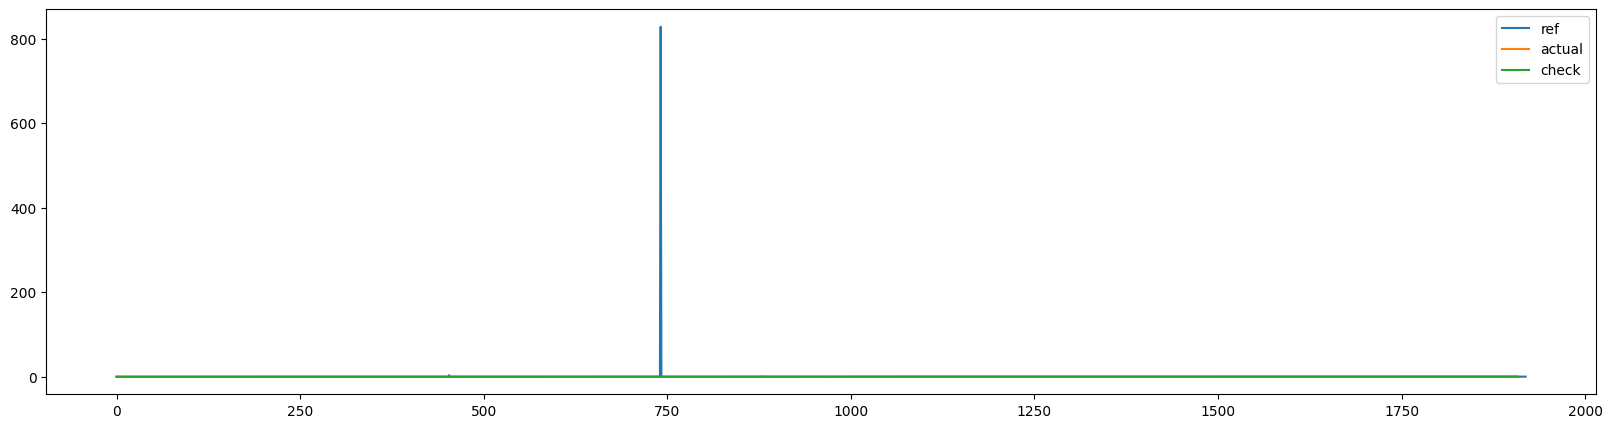

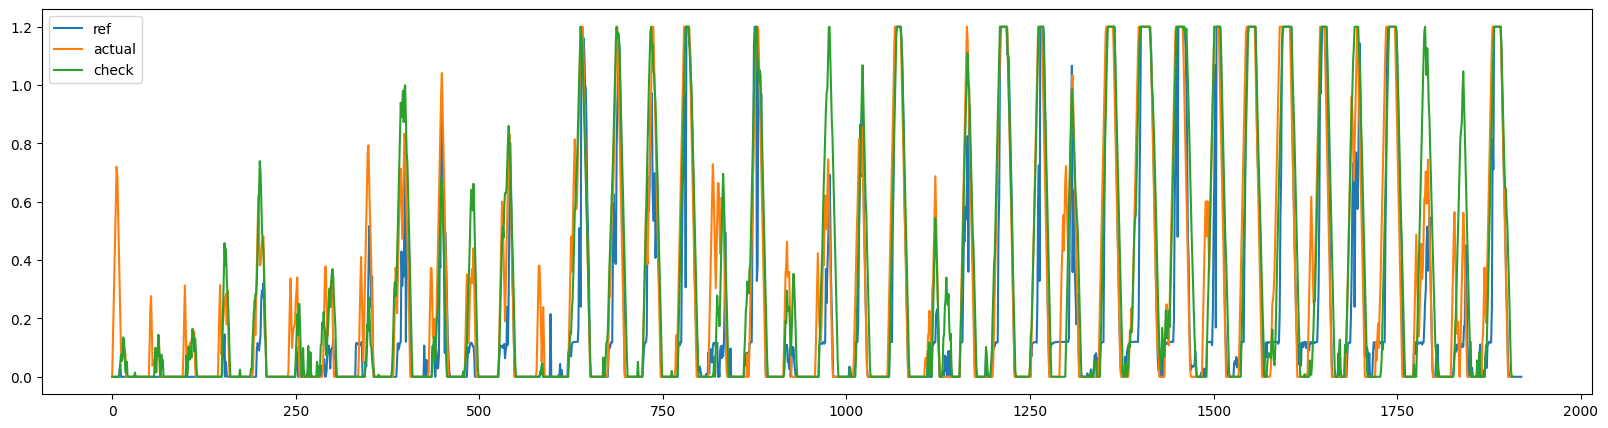

In [17]:
plt.figure(figsize=(20,5))
s = 0
plt.plot(   x_ref[:,s],label ="ref")
plt.plot(X_log[N-1:,s],label = 'actual')
plt.plot(check['x'][s,N:], label = 'check')
plt.legend()
# print (check['x'][0,-1])
# print (check['x'][0,:])
ss =0
plt.figure(figsize=(20,5))
plt.plot(   u_ref[:,ss],label ="ref")
plt.plot(U_log[N-1:,ss],label = 'actual')
plt.plot(check['u'][ss,N-1:], label = 'check')
plt.legend()


----------------------------  ----------
EPI                (EURO/m2)    5.043
Total growth       (kg/m2)      0.305595
Total C02 usage    (kg/m2)      0.994907
Total Heating      (kWh)       12.3153
Computational Time (s)          0.437681
Temp violations    (deg)       74.0394
C02 violations     (ppm)      925.079
FINAL PERFORMANCE               4.62633
----------------------------  ----------


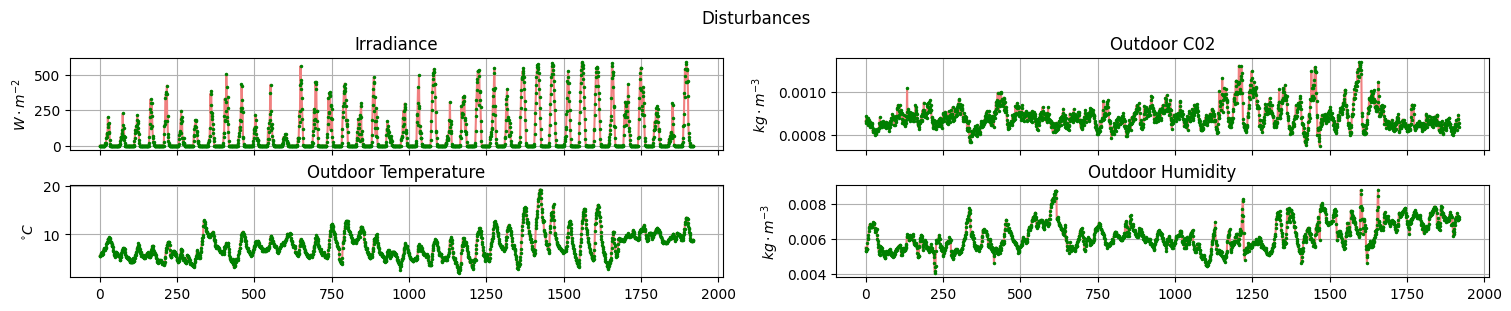

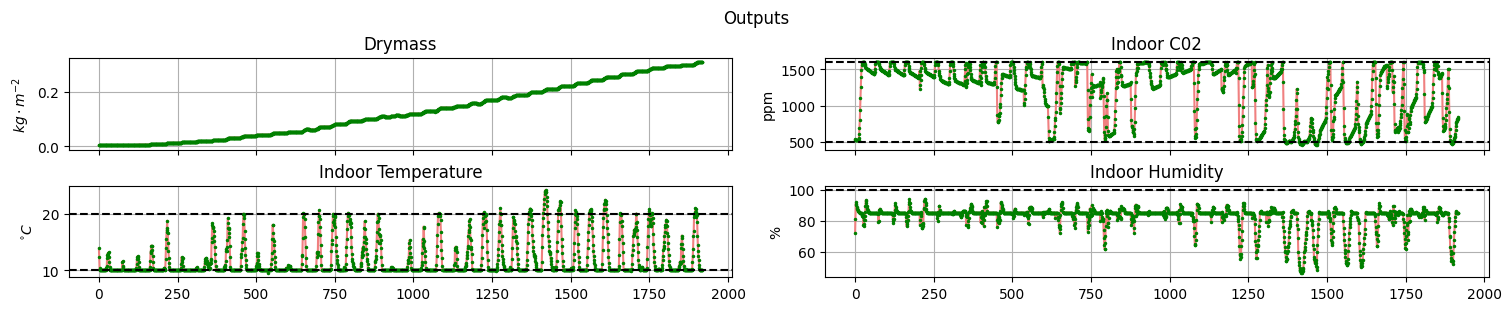

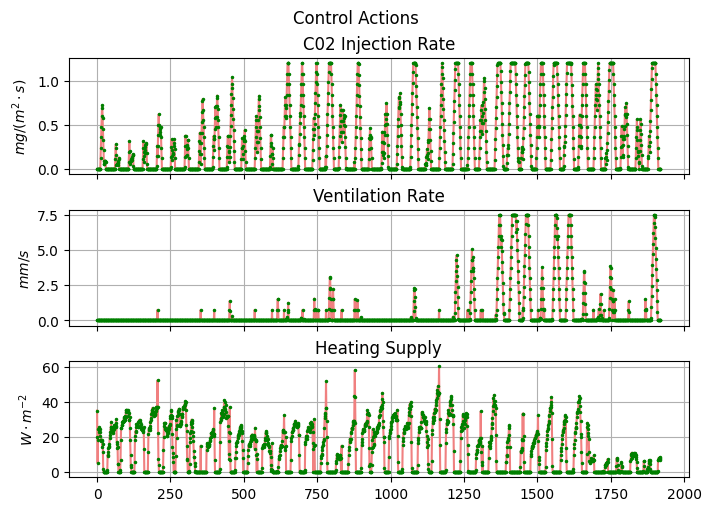

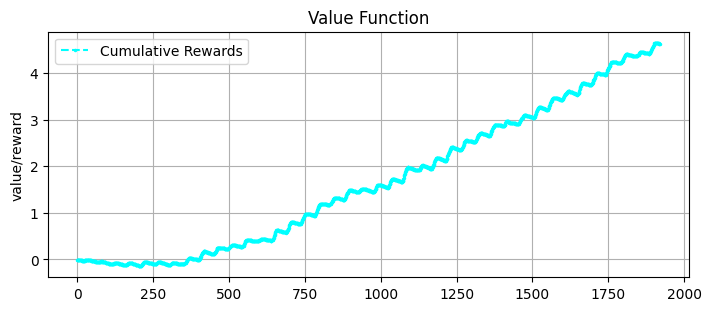

In [18]:

print_metrics(Y_log[:-1], U_log, D_log, day_range=(0,40), rewards=np.array(cum_reward_log)[1:], time_log=comp_time_log)

In [19]:
#4.7214